In [1]:
%cd /g/data/tm70/ds0092/projects/kerchunk_debug

/g/data/tm70/ds0092/projects/kerchunk_debug


In [2]:
import os

import ujson

import fsspec

import xarray as xr

import kerchunk
from kerchunk import hdf, combine

In [3]:
kerchunk.__version__

'0.1.0'

# Generate single-file reference jsons

This all works fine

In [4]:
fs = fsspec.filesystem('file')
files = fs.glob("./ds?.nc")

In [5]:
def gen_json(file):
    with fs.open(file) as infile:
        h5chunks = hdf.SingleHdf5ToZarr(
            infile,
            file,
        )
        outf = f"{os.path.splitext(file)[0]}.json"
        with open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());
            
for file in files:
    gen_json(file)

# Combine to multi-file reference json
The json file produced by running this cell has issues

In [6]:
combine.MultiZarrToZarr(
    fs.glob("./ds?.json"),
    concat_dims='time',
    identical_dims=[
        "xt_ocean", 
        "yt_ocean", 
        "nv"
    ],
).translate("./ds.json")

# Compare

In [7]:
def plot_vars(ds, label):
    import matplotlib.pyplot as plt
    d = ds.mean(["xt_ocean", "yt_ocean"])
    d["mld"].plot(label=label)
    plt.legend()

In [8]:
ds_nc = xr.open_mfdataset(fs.glob("./ds?.nc"))

In [9]:
m = [
    fsspec.get_mapper(
        'reference://', 
        fo=fo, 
        remote_protocol="file"
    ) for fo in fs.glob("./ds?.json")
]
ds_single = xr.open_mfdataset(
    m,
    engine='zarr', 
    backend_kwargs={"consolidated": False},
    chunks="auto",
)

In [10]:
m = fsspec.get_mapper(
    'reference://', 
    fo="./ds.json", 
    remote_protocol="file"
)

ds_multi = xr.open_dataset(
    m,
    engine='zarr', 
    backend_kwargs={"consolidated": False},
    chunks="auto",
)

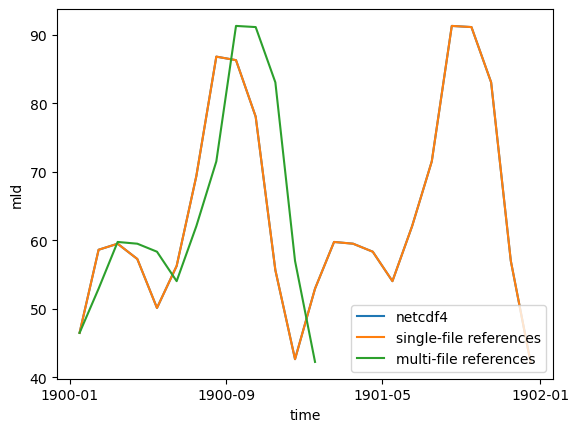

In [11]:
plot_vars(ds_nc, "netcdf4")
plot_vars(ds_single, "single-file references")
plot_vars(ds_multi, "multi-file references")